In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
from pathlib import Path

In [ ]:
class TileCoder:
    def __init__(self, num_tilings, tiles_per_dimension, env_low, env_high):
        self.num_tilings = num_tilings
        self.tiles_per_dimension = tiles_per_dimension
        self.env_low = np.array(env_low)
        self.env_high = np.array(env_high)
        self.tile_width = (self.env_high - self.env_low) / (tiles_per_dimension - 1)
        self.offsets = [(self.tile_width / num_tilings) * i for i in range(num_tilings)]

    def get_tile_code(self, observation):
        observation = np.array(observation)
        tile_codes = np.zeros(self.num_tilings * self.tiles_per_dimension**len(observation))
        for tiling in range(self.num_tilings):
            indices = []
            for i, val in enumerate(observation):
                index = int((val - self.env_low[i] + self.offsets[tiling][i]) / self.tile_width[i])
                index = min(index, self.tiles_per_dimension - 1)  # Ensure index is within bounds
                indices.append(index)
            tiling_index = tiling * (self.tiles_per_dimension**len(observation))
            flat_index = tiling_index + sum([indices[i] * (self.tiles_per_dimension ** i) for i in range(len(indices))])
            tile_codes[int(flat_index)] = 1
        return tile_codes

In [ ]:
class QLearning:
    def __init__(self, num_actions, tile_coder, alpha=0.1, gamma=0.99):
        self.num_actions = num_actions
        self.tile_coder = tile_coder
        self.alpha = alpha
        self.gamma = gamma
        num_state_dimensions = len(env.observation_space.low)  # Adjust based on the number of state variables
        num_features = tile_coder.num_tilings * (tile_coder.tiles_per_dimension ** num_state_dimensions)
        self.theta = np.random.uniform(-0.001, 0.001, (num_actions, num_features))

    def choose_action(self, observation, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_actions)
        else:
            q_values = self.get_q_values(observation)
            return np.argmax(q_values)

    def get_q_values(self, observation):
        features = self.tile_coder.get_tile_code(observation)
        return np.dot(self.theta, features)

    def update(self, observation, action, reward, next_observation):
        features = self.tile_coder.get_tile_code(observation)
        next_features = self.tile_coder.get_tile_code(next_observation)
        q_values_next = np.dot(self.theta, next_features)
        target = reward + self.gamma * np.max(q_values_next)
        td_error = target - np.dot(self.theta[action], features)
        self.theta[action] += self.alpha * td_error * features



100%|██████████| 5/5 [03:08<00:00, 37.67s/it]


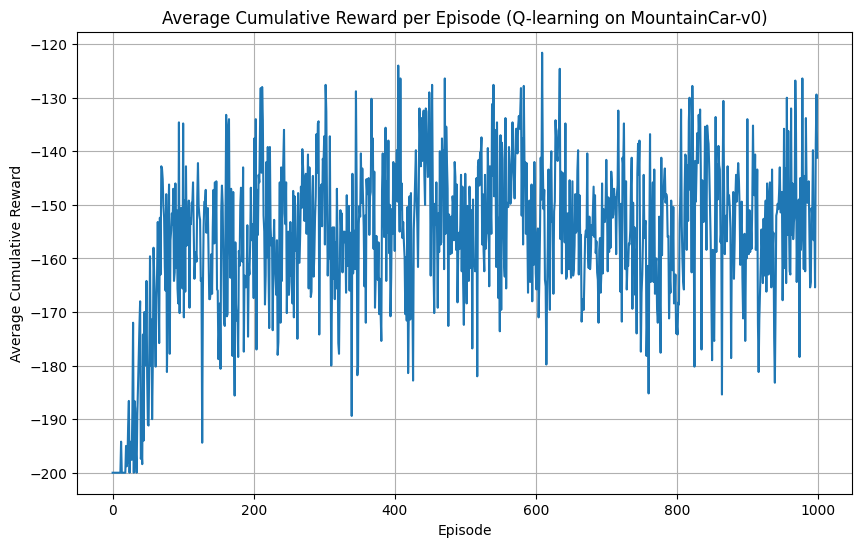

In [ ]:
# Initialize the MountainCar-v0 environment
env = gym.make('MountainCar-v0')
env.seed(0)  # For reproducibility

# Parameters for the experiment
num_trials = 5  # Reduced from 50 for demonstration
num_episodes = 1000  # Reduced from 1000 for demonstration
epsilon = 0.05  # Epsilon for the epsilon-greedy policy
alpha = 1/8  # Learning rate
gamma = 0.99  # Discount factor

# Environment parameters
env_low = env.observation_space.low
env_high = env.observation_space.high
num_actions = env.action_space.n

# Initialize tile coder
tile_coder = TileCoder(num_tilings=8, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Function to run a single trial
def run_trial():
    q_learning = QLearning(num_actions, tile_coder, alpha=alpha, gamma=gamma)
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        total_reward = 0
        observation = env.reset()
        done = False
        while not done:
            action = q_learning.choose_action(observation, epsilon)
            next_observation, reward, done, info = env.step(action)
            q_learning.update(observation, action, reward, next_observation)
            observation = next_observation
            total_reward += reward
        episode_rewards[episode] = total_reward
    return episode_rewards

# Run trials and collect performance data
all_rewards = np.array([run_trial() for _ in tqdm(range(num_trials))])

# Calculate the average performance over all trials
average_rewards = np.mean(all_rewards, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_rewards)
plt.title('Average Cumulative Reward per Episode (Q-learning on MountainCar-v0)')
plt.xlabel('Episode')
plt.ylabel('Average Cumulative Reward')
plt.grid()
plt.show()

In [ ]:
# Initialize the MountainCar-v0 environment
env = gym.make('MountainCar-v0')
env.seed(0)  # For reproducibility

# Environment parameters
env_low = env.observation_space.low
env_high = env.observation_space.high
num_actions = env.action_space.n

# Initialize tile coder
tile_coder = TileCoder(num_tilings=2, tiles_per_dimension=10, env_low=env_low, env_high=env_high)

# Parameters for the experiments
epsilons = [0.01, 0.03, 0.05]
alphas = [1/4, 1/8, 1/16]
num_trials = 50
num_episodes = 1000
gamma = 0.99

results = {}

# Function to run a single trial
def run_trial(alpha, epsilon):
    q_learning = QLearning(num_actions, tile_coder, alpha=alpha, gamma=gamma)
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        total_reward = 0
        observation = env.reset()
        done = False
        while not done:
            action = q_learning.choose_action(observation, epsilon)
            next_observation, reward, done, info = env.step(action)
            q_learning.update(observation, action, reward, next_observation)
            observation = next_observation
            total_reward += reward
        episode_rewards[episode] = total_reward
    return episode_rewards

# Run experiments
setting_id = 1
for epsilon in epsilons:
    for alpha in alphas:
        trial_rewards = []
        for trial in tqdm(range(num_trials), desc=f'Alpha: {alpha}, Epsilon: {epsilon}'):
            trial_rewards.append(run_trial(alpha, epsilon))

        trial_rewards = np.array(trial_rewards)

        # Calculate statistics for the trials across all episodes
        upper_quantiles = np.quantile(trial_rewards, 0.75, axis=0)
        means = np.mean(trial_rewards, axis=0)
        lower_quantiles = np.quantile(trial_rewards, 0.25, axis=0)

        setting_key = f"setting{setting_id}"
        results[setting_key] = {
            "epsilon": epsilon,
            "alpha": alpha,
            "50_trials": {
                "1000_episodes_upper_quantile": upper_quantiles.tolist(),
                "1000_episodes_mean": means.tolist(),
                "1000_episodes_lower_quantile": lower_quantiles.tolist()
            }
        }
        setting_id += 1

# Save results to a JSON file for MountainCar-v0
output_path = './test/q_learning_task1.json'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'w') as fp:
    json.dump(results, fp, indent=4)

print(f"Experiment results for MountainCar-v0 saved to {output_path}")

Alpha: 0.0625, Epsilon: 0.05: 100%|██████████| 50/50 [09:46<00:00, 11.72s/it]


NameError: name 'os' is not defined

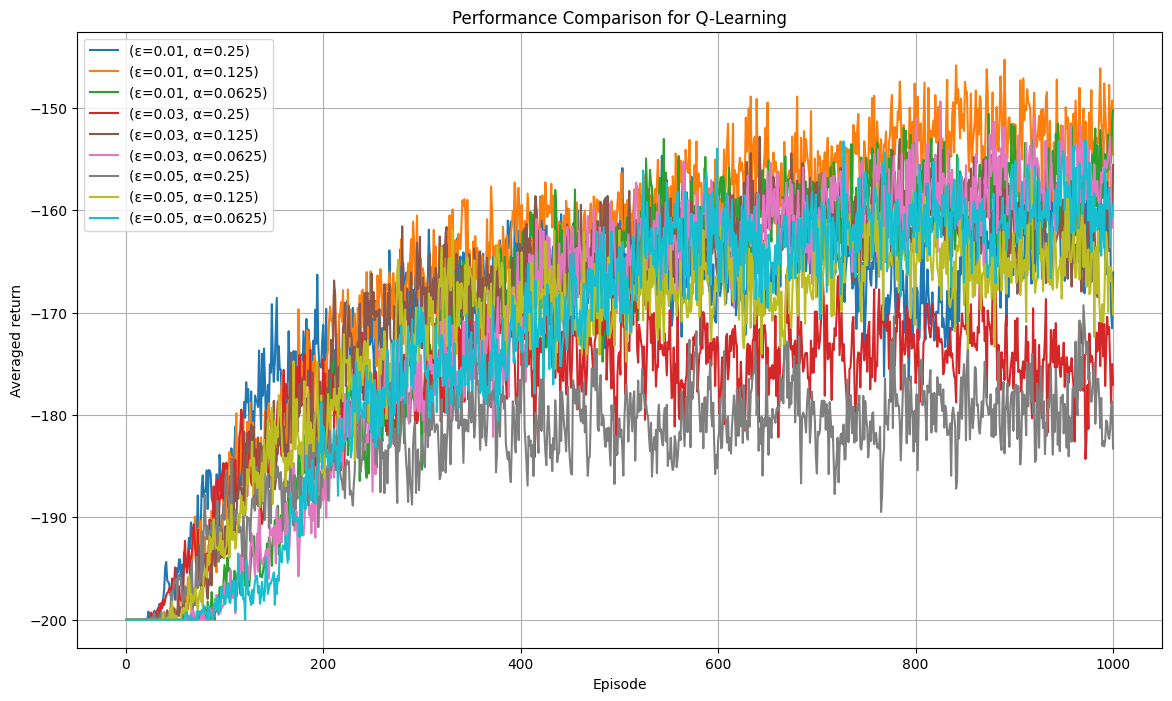

In [ ]:
# Load the JSON data from the file
file_path = '/content/test/q_learning_task1.json'  # Make sure to replace this with the actual path to your JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize the figure
plt.figure(figsize=(14, 8))

# Define a color palette for visual distinction
color_palette = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Assuming episodes range from 1 to 1000
episodes = np.arange(1, 1001)

for i, (setting, details) in enumerate(data.items()):
    # Extract performance data
    mean_performance = details['50_trials']['1000_episodes_mean']
    upper_quantile_performance = details['50_trials']['1000_episodes_upper_quantile']
    lower_quantile_performance = details['50_trials']['1000_episodes_lower_quantile']

    # Plot mean performance with a specific color and solid line
    plt.plot(episodes, mean_performance, label=f"(ε={details['epsilon']}, α={details['alpha']})",
             color=color_palette[i % len(color_palette)], linestyle='-')

    # Add shaded interquantile region
    # plt.fill_between(episodes, lower_quantile_performance, upper_quantile_performance, color=color_palette[i % len(color_palette)], alpha=0.2)

plt.title('Performance Comparison for Q-Learning')
plt.xlabel('Episode')
plt.ylabel('Averaged return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class REINFORCE:
    def __init__(self, num_actions, tile_coder, alpha=0.1, gamma=0.99, temperature=1.0):
        self.num_actions = num_actions
        self.tile_coder = tile_coder
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature
        num_features = tile_coder.num_tilings * (tile_coder.tiles_per_dimension ** len(env.observation_space.low))
        self.theta = np.random.uniform(-0.001, 0.001, (num_actions, num_features))

    def get_policy(self, observation):
        z_values = np.dot(self.theta, self.tile_coder.get_tile_code(observation))
        exp_values = np.exp(z_values / self.temperature)
        probabilities = exp_values / np.sum(exp_values)
        return probabilities

    def choose_action(self, observation):
        probabilities = self.get_policy(observation)
        action = np.random.choice(np.arange(self.num_actions), p=probabilities)
        return action

    def update(self, episode):
        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            features = self.tile_coder.get_tile_code(state)
            pi = self.get_policy(state)
            self.theta -= self.alpha * (self.gamma ** t) * (pi - (action == np.arange(self.num_actions)).astype(float))[:, None] * features * G

Trial:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Trial: 100%|██████████| 5/5 [03:16<00:00, 39.26s/it]


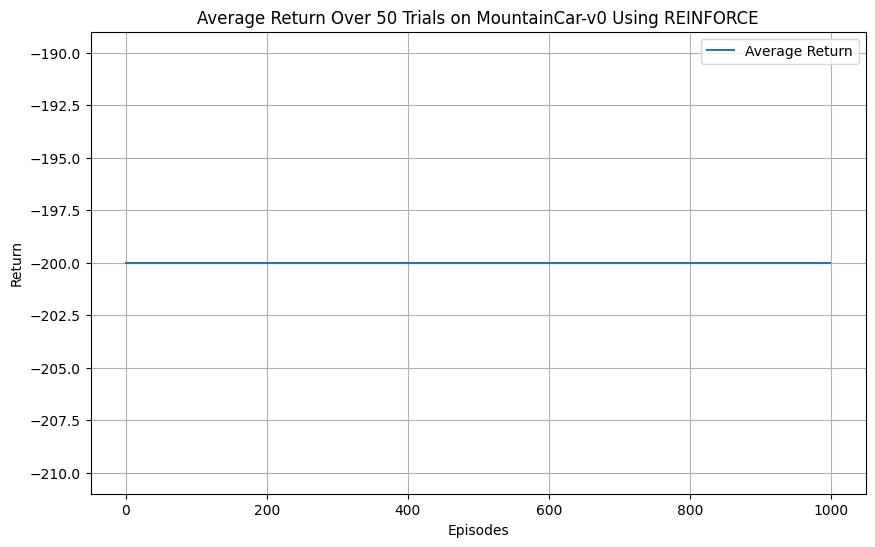

In [ ]:
# Assuming REINFORCE and TileCoder classes are defined

def run_reinforce_trial(env, agent, num_episodes):
    total_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        episode_rewards = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update([(state, action, reward)])
            state = next_state
            episode_rewards += reward
        total_rewards[episode] = episode_rewards
    return total_rewards

# Parameters
num_trials = 5
num_episodes = 1000
alpha = 0.01  # Learning rate
gamma = 0.99  # Discount factor
temperature = 0.001  # Fixed temperature

# Environment setup
env = gym.make('MountainCar-v0')

# Results storage
all_rewards = np.zeros((num_trials, num_episodes))

# Running the trials
for trial in tqdm(range(num_trials), desc='Trial'):
    env.seed(trial)  # Set a different seed for each trial
    tile_coder = TileCoder(num_tilings=2, tiles_per_dimension=10, env_low=env.observation_space.low, env_high=env.observation_space.high)
    agent = REINFORCE(env.action_space.n, tile_coder, alpha, gamma, temperature)
    all_rewards[trial] = run_reinforce_trial(env, agent, num_episodes)

# Calculating the average return over trials
average_rewards = np.mean(all_rewards, axis=0)

# Plotting the average return over episodes
plt.figure(figsize=(10, 6))
plt.plot(average_rewards, label='Average Return')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Average Return Over 50 Trials on MountainCar-v0 Using REINFORCE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
class REINFORCE:
    def __init__(self, tile_coder, num_actions, learning_rate=0.01, gamma=0.99, temperature=1.0):
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.temperature = temperature
        # Dynamically adjust theta's shape based on tile_coder output size
        feature_vector_size = len(tile_coder.get_tile_code([0.0] * len(env.observation_space.high)))
        self.theta = np.random.rand(num_actions, feature_vector_size) * 0.01  # Adjusted initialization

    def policy(self, state):
        x = self.tile_coder.get_tile_code(state)  # Get tile-coded state
        z = np.dot(self.theta, x)  # Compute z values for all actions
        exp_z = np.exp(z / self.temperature)
        policy = exp_z / np.sum(exp_z)  # Softmax
        return policy

    def choose_action(self, state):
        policy = self.policy(state)
        action = np.random.choice(range(self.num_actions), p=policy)  # Choose action based on policy probabilities
        return action

    def update(self, states, actions, rewards):
        G = 0
        for t in reversed(range(len(states))):
            x = self.tile_coder.get_tile_code(states[t])
            G = self.gamma * G + rewards[t]
            probs = self.policy(states[t])
            dlog = -probs  # derivative of log pi for all actions
            dlog[actions[t]] += 1  # For taken action
            for a in range(self.num_actions):
                self.theta[a] += self.learning_rate * G * dlog[a] * x

In [ ]:
def update_temperature(initial_temp, episode, num_episodes, min_temp):
    # Adjust the decreasing temperature strategy to use a minimum temperature
    return max(min_temp, initial_temp - (initial_temp - min_temp) * (episode / num_episodes))

def run_trials(env, num_trials, num_episodes, tile_coder, fixed_temp, initial_temp, discount_rate_change, min_temp):
    settings = ["setting_fixed_tmp", "setting_decreasing_tmp"]
    results = {}
    num_actions = env.action_space.n

    for setting in settings:
        all_rewards = np.zeros((num_trials, num_episodes))
        for trial in tqdm(range(num_trials)):
            temperature = fixed_temp if setting == "setting_fixed_tmp" else initial_temp
            agent = REINFORCE(tile_coder, num_actions, learning_rate=0.1, gamma=0.99, temperature=temperature)

            for episode in range(num_episodes):
                if setting == "setting_decreasing_tmp":
                    agent.temperature = update_temperature(initial_temp, episode, num_episodes, min_temp)
                    agent.gamma = max(0.1, agent.gamma * discount_rate_change)  # Adjust discount rate per episode
                state, done, ep_rewards = env.reset(), False, 0

                while not done:
                    action = agent.choose_action(state)
                    next_state, reward, done, _ = env.step(action)
                    agent.update([state], [action], [reward])
                    state = next_state
                    ep_rewards += reward

                all_rewards[trial, episode] = ep_rewards

        results[setting] = {
            "50_trials": {
                "1000_episodes_upper_quantile": np.percentile(all_rewards, 75, axis=0).tolist(),
                "1000_episodes_mean": np.mean(all_rewards, axis=0).tolist(),
                "1000_episodes_lower_quantile": np.percentile(all_rewards, 25, axis=0).tolist(),
            }
        }

    return results

# Create the environment outside of the run_trials function
env_name = 'CartPole-v1'
env = gym.make(env_name)
env.seed(0)  # Ensure reproducibility

# Assuming TileCoder is already defined
# Manually set the state bounds for CartPole-v1 environment
env_low = np.array([-2.4, -2, -0.418, -2])
env_high = np.array([2.4, 2, 0.418, 2])
tile_coder = TileCoder(4, 8, env_low, env_high)

# Adjusted parameters
fixed_temp = 1.0  # Fixed temperature for setting 1
initial_temp = 10  # Initial temperature for setting 2
discount_rate_change = 0.995  # How the discount rate changes each episode for setting 2
min_temp = 0.01  # Minimum temperature for setting 2

num_trials = 5
num_episodes = 1000

# Running the trials with adjusted parameters
results = run_trials(env, num_trials, num_episodes, tile_coder, fixed_temp, initial_temp, discount_rate_change, min_temp)

# Save results to JSON file
output_path = Path("./test/REINFORCE_task2.json")
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, "w") as fp:
    json.dump(results, fp)

print("Experiment results saved.")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for 

Experiment results saved.


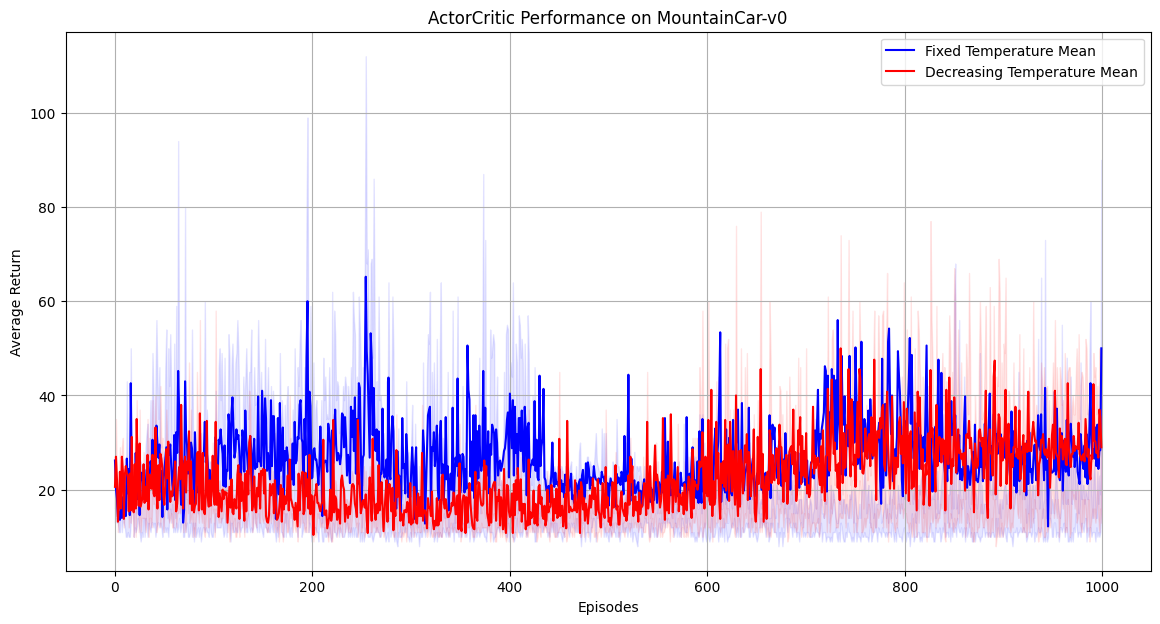

In [ ]:
# Load the data
with open("/content/test/REINFORCE_task2.json", "r") as json_file:
    results = json.load(json_file)

# Extract data for plotting
fixed_temp_means = results['setting_fixed_tmp']['50_trials']['1000_episodes_mean']
fixed_temp_upper = results['setting_fixed_tmp']['50_trials']['1000_episodes_upper_quantile']
fixed_temp_lower = results['setting_fixed_tmp']['50_trials']['1000_episodes_lower_quantile']

decreasing_temp_means = results['setting_decreasing_tmp']['50_trials']['1000_episodes_mean']
decreasing_temp_upper = results['setting_decreasing_tmp']['50_trials']['1000_episodes_upper_quantile']
decreasing_temp_lower = results['setting_decreasing_tmp']['50_trials']['1000_episodes_lower_quantile']

# Plotting
plt.figure(figsize=(14, 7))

# Fixed temperature
plt.fill_between(range(1000), fixed_temp_lower, fixed_temp_upper, color='blue', alpha=0.1)
plt.plot(fixed_temp_means, label='Fixed Temperature Mean', color='blue')

# Decreasing temperature
plt.fill_between(range(1000), decreasing_temp_lower, decreasing_temp_upper, color='red', alpha=0.1)
plt.plot(decreasing_temp_means, label='Decreasing Temperature Mean', color='red')

plt.title('ActorCritic Performance on MountainCar-v0')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()